In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

### 生成数据

这里用马尔科夫假设生成模型

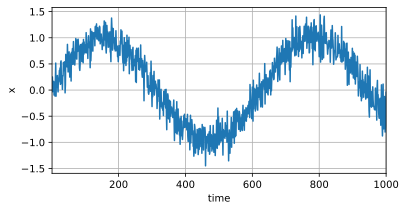

In [19]:
T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32) # 步长 1, 2, 3,...,1000
x = torch.sin(0.01 * time) + torch.normal(0, 0.20, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [20]:
x.shape

torch.Size([1000])

若 $y_t$ 作为标签，那么 $[x_{t-\xi},...,x_{t-1}]$ 作为特征训练，这里选择 4 作为特征数

In [37]:
tau = 4
""" 样本为 T - tau，是因为从第一个到第 tau个样本都找不到前 tau 个样本来预测，那么样本就要从第 tau + 1 个开始，一共 T - tau 个"""
features = torch.zeros(T - tau, tau)
for i in range(tau):
    features[:, i] = x[i: T - tau + i] # 将每个样本的特征赋值, 保证有 T - tau 个值
labels = x[tau:].reshape(-1, 1)

batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

### 模型构建

In [26]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

In [28]:
def get_net():
    net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

In [29]:
loss = nn.MSELoss()

In [30]:
def train(net: nn.Module, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}', f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1 loss: 0.053982
epoch 2 loss: 0.048498
epoch 3 loss: 0.047014
epoch 4 loss: 0.045569
epoch 5 loss: 0.045813


### 预测

单步预测

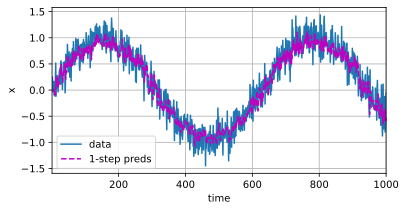

In [31]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

第一个预测是 n_train + tau - 1，使用已有训练数据的预测 ，从 n_train + tau 到 T 的数据需要使用我们预测了的数据去预测

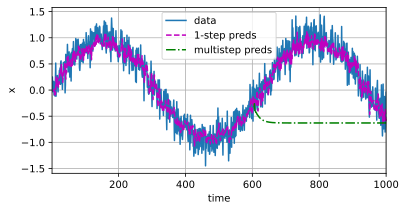

In [35]:
multisteps_preds = torch.zeros(T)
multisteps_preds[: n_train + tau] = x[: n_train + tau]
""" 这里是预测第 604 到 第 1000 个样本，使用预测出来的值去预测值 """
for i in range(n_train + tau, T):
    multisteps_preds[i] = net(multisteps_preds[i - tau:i].reshape(1, -1)) # 用前 tau 个数据预测

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multisteps_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

以下分别进行多步预测（1, 4, 16, 64），比如 4 就是给 4 个点预测未来 4 个点，从第二个点开始就要使用预测过的值作为特征进行预测

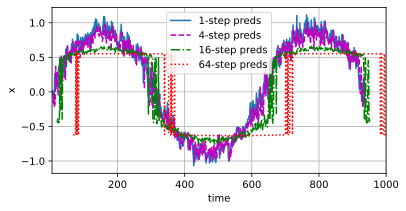

In [36]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))